In [3]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, execute, QuantumRegister, ClassicalRegister
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

from qiskit_ibm_provider import IBMProvider
import qiskit_ibm_provider

from time import perf_counter

provider = IBMProvider()

In [4]:
'''
params
---------------
picture: square 2d array of integers representing grayscale values
assume the length (n) is some power of 2

return
---------------
a flattened representation of picture using bitstrings (boolean arrays)
'''
def convert_to_bits (picture):
    n = len(picture)
    ret = []
    for i in range(n):
        for j in range(n):
            value = picture[i][j]
            bitstring = bin(value)[2:]
            ret.append([0 for i in range(8 - len(bitstring))] + [1 if c=='1' else 0 for c in bitstring])
    return ret

'''
params
----------------
bitStr: a representation of an image using bitstrings to represent grayscale values

return
----------------
A quantum circuit containing the NEQR representation of the image
'''
def neqr(bitStr): 
    newBitStr = bitStr

    #print(newBitStr)
    #print("\n")

    # Pixel position
    idx = QuantumRegister(np.ceil(np.log2(len(newBitStr))), 'idx')

    # Pixel intensity values
    intensity = QuantumRegister(8, 'intensity')

    # Classical Register
    creg = ClassicalRegister(10, 'creg')

    # Quantum Image Representation as a quantum circuit
    # with Pixel Position and Intensity registers
    quantumImage = QuantumCircuit(intensity, idx, creg)

    numOfQubits = quantumImage.num_qubits
    print("\n>> Initial Number of Qubits:", numOfQubits)

    # -----------------------------------
    # Drawing the Quantum Circuit
    # -----------------------------------
    lengthIntensity = intensity.size
    lengthIdx = idx.size

    start = perf_counter()

    quantumImage.i([intensity[lengthIntensity-1-i] for i in range(lengthIntensity)])
    quantumImage.h([idx[lengthIdx-1-i] for i in range(lengthIdx)])

    numOfPixels = len(newBitStr)

    for i in range(numOfPixels):
        bin_ind = bin(i)[2:]
        bin_ind = (lengthIdx - len(bin_ind)) * '0' + bin_ind
        bin_ind = bin_ind[::-1]

        # X-gate (enabling zero-controlled nature)
        for j in range(len(bin_ind)):
            if bin_ind[j] == '0':
                quantumImage.x(idx[j])

        # Configuring Multi-Qubit Controlled-NOT (mcx) gates with control and target qubits
        for j in range(len(newBitStr[i])):
            if newBitStr[i][j] == 1:
                quantumImage.mcx(idx, intensity[lengthIntensity-1-j])
        
        # X-gate (reversing the Negated state of the qubits)
        for j in range(len(bin_ind)):
            if bin_ind[j] == '0':
                quantumImage.x(idx[j])
        
        quantumImage.barrier()

    quantumImage.measure_all() # (range(10), range(10))

    end = perf_counter()
    print(f">> Circuit construction took {(end-start)} seconds.")

    return (quantumImage, intensity)

if __name__ == '__main__':
    test_picture_2x2 = [[0, 100], [200, 255]]
    test_picture_3x3 = [[25, 50, 75], [100, 125, 150], [175, 200, 225]]
    test_picture_4x4 = [[0, 100, 143, 83], [200, 255, 43, 22], [12, 234, 23, 5], [112, 113, 117, 125]]
    test_picture_5x5 = [[0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32]]
    
    arr = convert_to_bits(test_picture_2x2)
    arr1 = convert_to_bits(test_picture_3x3)
    arr2 = convert_to_bits(test_picture_4x4)
    arr3 = convert_to_bits(test_picture_5x5)
    
    #print("2x2: ", arr, "\n") 
    print("3x3: ", arr1, "\n") 
    #print("4x4: ", arr2, "\n") 
    #print("5x5: ", arr3, "\n") 
    
    qc_image, _ = neqr(arr1)

3x3:  [[0, 0, 0, 1, 1, 0, 0, 1], [0, 0, 1, 1, 0, 0, 1, 0], [0, 1, 0, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 1, 1, 1, 1], [1, 1, 0, 0, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 1]] 


>> Initial Number of Qubits: 12
>> Circuit construction took 0.0049141229974338785 seconds.


In [5]:
#qc_image.draw()

┌───┐               ┌───┐      ░                           ░      »
intensity_0: ┤ I ├───────────────┤ X ├──────░───────────────────────────░──────»
             ├───┤               └─┬─┘      ░                ┌───┐      ░      »
intensity_1: ┤ I ├─────────────────┼────────░────────────────┤ X ├──────░──────»
             ├───┤                 │        ░                └─┬─┘      ░      »
intensity_2: ┤ I ├─────────────────┼────────░──────────────────┼────────░──────»
             ├───┤          ┌───┐  │        ░                  │        ░      »
intensity_3: ┤ I ├──────────┤ X ├──┼────────░──────────────────┼────────░──────»
             ├───┤     ┌───┐└─┬─┘  │        ░           ┌───┐  │        ░      »
intensity_4: ┤ I ├─────┤ X ├──┼────┼────────░───────────┤ X ├──┼────────░──────»
             ├───┤     └─┬─┘  │    │        ░      ┌───┐└─┬─┘  │        ░      »
intensity_5: ┤ I ├───────┼────┼────┼────────░──────┤ X ├──┼────┼────────░──────»
             ├───┤       │    │    │        ░      └─┬─┘  │    │        ░      »
intensity_6: ┤ I ├───────┼────┼────┼────────░────────┼────┼────┼────────░──────»
             ├───┤       │    │    │        ░        │    │    │        ░      »
intensity_7: ┤ I ├───────┼────┼────┼────────░────────┼────┼────┼────────░──────»
             ├───┤┌───┐  │    │    │  ┌───┐ ░        │    │    │        ░ ┌───┐»
      idx_0: ┤ H ├┤ X ├──■────■────■──┤ X ├─░────────■────■────■────────░─┤ X ├»
             ├───┤├───┤  │    │    │  ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ └───┘»
      idx_1: ┤ H ├┤ X ├──■────■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░──────»
             ├───┤├───┤  │    │    │  ├───┤ ░ ├───┤  │    │    │  ├───┤ ░ ┌───┐»
      idx_2: ┤ H ├┤ X ├──■────■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─┤ X ├»
             ├───┤├───┤  │    │    │  ├───┤ ░ ├───┤  │    │    │  ├───┤ ░ ├───┤»
      idx_3: ┤ H ├┤ X ├──■────■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─┤ X ├»
             └───┘└───┘               └───┘ ░ └───┘               └───┘ ░ └───┘»
    creg: 10/══════════════════════════════════════════════════════════════════»
                                                                               »
    meas: 12/══════════════════════════════════════════════════════════════════»
                                                                               »
«                            ┌───┐      ░                           ░      »
«intensity_0: ───────────────┤ X ├──────░───────────────────────────░──────»
«                       ┌───┐└─┬─┘      ░                           ░      »
«intensity_1: ──────────┤ X ├──┼────────░───────────────────────────░──────»
«                       └─┬─┘  │        ░                ┌───┐      ░      »
«intensity_2: ────────────┼────┼────────░────────────────┤ X ├──────░──────»
«                  ┌───┐  │    │        ░                └─┬─┘      ░      »
«intensity_3: ─────┤ X ├──┼────┼────────░──────────────────┼────────░──────»
«                  └─┬─┘  │    │        ░                  │        ░      »
«intensity_4: ───────┼────┼────┼────────░──────────────────┼────────░──────»
«                    │    │    │        ░           ┌───┐  │        ░      »
«intensity_5: ───────┼────┼────┼────────░───────────┤ X ├──┼────────░──────»
«             ┌───┐  │    │    │        ░      ┌───┐└─┬─┘  │        ░      »
«intensity_6: ┤ X ├──┼────┼────┼────────░──────┤ X ├──┼────┼────────░──────»
«             └─┬─┘  │    │    │        ░      └─┬─┘  │    │        ░      »
«intensity_7: ──┼────┼────┼────┼────────░────────┼────┼────┼────────░──────»
«               │    │    │    │  ┌───┐ ░        │    │    │        ░ ┌───┐»
«      idx_0: ──■────■────■────■──┤ X ├─░────────■────■────■────────░─┤ X ├»
«               │    │    │    │  └───┘ ░        │    │    │        ░ ├───┤»
«      idx_1: ──■────■────■────■────────░────────■────■────■────────░─┤ X ├»
«               │    │    │    │  ┌───┐ ░ ┌───┐  │    │    │  ┌───┐ ░ └───┘»
«      idx_2: ──■────■────■────■──┤ X ├─░─┤ X ├

In [ ]:
from qiskit.compiler import assemble
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)

shots = 1024

qobj = assemble(t_qc_image, shots=shots)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

print("\nExpected Counts per pixel = ", shots/len(arr))
print("Experimental Counts", counts_neqr)
print("\nExpected probability for each pixel = ", 1.0/(len(arr)))
plot_histogram(counts_neqr)


---


In [1]:
%matplotlib inline

In [2]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [16]:
img = np.asarray(arr2)
print(repr(img))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 1, 0, 1],
       [0, 1, 1, 1, 1, 1, 0, 1]])


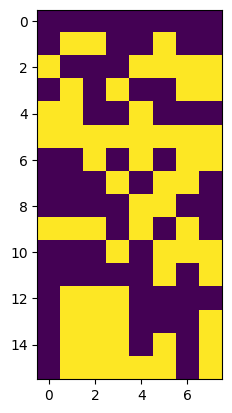

In [17]:
imgplot = plt.imshow(img)